In [1]:
import os
import sys
import re
import gc
from os.path import join

import torch
import anndata
import numpy as np
import pandas as pd
import xgboost as xgb
import dask.dataframe as dd
import pandas as pd
import lightning.pytorch as pl
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.metrics import classification_report

sys.path.append("/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/")
from emb_cellnet.estimators import EstimatorCellTypeClassifier
from emb_cellnet.models import TabnetClassifier, LinearClassifier, MLPClassifier

sys.path.append("/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/scTab-devel/notebooks/model_evaluation")
from utils import correct_labels, get_best_ckpts, macro_f1_per_group, BIONETWORK_GROUPING

/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/tritonclient/grpc/service_pb2_grpc.py:21: RuntimeWarning: The grpc package installed is at version 1.62.2, but the generated code in grpc_service_pb2_grpc.py depends on grpcio>=1.65.5. Please upgrade your grpc module to grpcio>=1.65.5 or downgrade your generated code using grpcio-tools<=1.62.2. This warning will become an error in 1.66.0, scheduled for release on August 6, 2024.
  warnings.warn(


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


'cpu'

In [3]:
DATA_PATH = '/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Embedding'
test_emb = torch.load(join(DATA_PATH, "test_embedding.pt"), weights_only=True)

y_test = test_emb["y_true"]    # shape [N]
X_test = test_emb["X"]         # shape [N, D]
unique_labels = torch.unique(y_test)

In [4]:
CKPT_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Model_softmax/timestep_analysis/variance_based_sampling/T=50"
y_pred_t50 =  np.load(join(CKPT_PATH, 'y_pred_all.npy'))

In [5]:
CKPT_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Model_softmax/timestep_analysis/variance_based_sampling/T=100"
y_pred_t100 =  np.load(join(CKPT_PATH, 'y_pred_all.npy'))

In [6]:
CKPT_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Model_softmax/timestep_analysis/variance_based_sampling/T=250"
y_pred_t250 =  np.load(join(CKPT_PATH, 'y_pred_all.npy'))

In [7]:
# CKPT_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Model_softmax/timestep_analysis/sub_sample_beta/T=500"
CKPT_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Model_softmax/timestep_analysis/variance_based_sampling/T=500"
y_pred_t500 =  np.load(join(CKPT_PATH, 'y_pred_all.npy'))

In [8]:
CKPT_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Model_softmax/timestep_analysis/variance_based_sampling/T=600"
y_pred_t600 =  np.load(join(CKPT_PATH, 'y_pred_all.npy'))

In [9]:
CKPT_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Model_softmax/timestep_analysis/variance_based_sampling/T=700"
y_pred_t700 =  np.load(join(CKPT_PATH, 'y_pred_all.npy'))

In [10]:
CKPT_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Model_softmax/timestep_analysis/variance_based_sampling/T=800"
y_pred_t800 =  np.load(join(CKPT_PATH, 'y_pred_all.npy'))

In [11]:
CKPT_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Model_softmax/timestep_analysis/variance_based_sampling/T=1000"
y_pred_t1000 =  np.load(join(CKPT_PATH, 'y_pred_all.npy'))

In [12]:
CKPT_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Model_softmax/timestep_analysis/variance_based_sampling/T=1000_original"
y_pred_t1000_orig =  np.load(join(CKPT_PATH, 'y_pred_all.npy'))

In [13]:
y_true = np.arange(len(unique_labels))

In [14]:
y_pred_t50 = np.asarray(y_pred_t50, dtype=np.int64).ravel()
y_pred_t100 = np.asarray(y_pred_t100, dtype=np.int64).ravel()
y_pred_t250 = np.asarray(y_pred_t250, dtype=np.int64).ravel()
y_pred_t500 = np.asarray(y_pred_t500, dtype=np.int64).ravel()
y_pred_t600 = np.asarray(y_pred_t600, dtype=np.int64).ravel()
y_pred_t700 = np.asarray(y_pred_t700, dtype=np.int64).ravel()
y_pred_t800 = np.asarray(y_pred_t800, dtype=np.int64).ravel()
y_pred_t1000 = np.asarray(y_pred_t1000, dtype=np.int64).ravel()
y_pred_t1000_orig = np.asarray(y_pred_t1000_orig, dtype=np.int64).ravel()

In [15]:
print("y_true:", len(y_true))
print("y_pred_t100:", len(y_pred_t50))

y_true: 164
y_pred_t100: 164


In [16]:
from sklearn.metrics import f1_score
import numpy as np

# Compute macro F1 once per model
f1_t50 = f1_score(y_true, y_pred_t50, average="macro")
f1_t100 = f1_score(y_true, y_pred_t100, average="macro")
f1_t250 = f1_score(y_true, y_pred_t250, average="macro")
f1_t500 = f1_score(y_true, y_pred_t500, average="macro")
f1_t600 = f1_score(y_true, y_pred_t600, average="macro")
f1_t700 = f1_score(y_true, y_pred_t700, average="macro")
f1_t800 = f1_score(y_true, y_pred_t800, average="macro")
f1_t1000 = f1_score(y_true, y_pred_t1000, average="macro")
f1_t1000_orig = f1_score(y_true, y_pred_t1000_orig, average="macro")

print(f"T=50 F1: {f1_t50:.3f}")
print(f"T=100 F1: {f1_t100:.3f}")
print(f"T=250 F1: {f1_t250:.3f}")
print(f"T=500 F1: {f1_t500:.3f}")
print(f"T=600 F1: {f1_t600:.3f}")
print(f"T=700 F1: {f1_t700:.3f}")
print(f"T=800 F1: {f1_t800:.3f}")
print(f"T=1000 F1: {f1_t1000:.3f}")
print(f"T=1000_orig F1: {f1_t1000_orig:.3f}")

T=50 F1: 0.827
T=100 F1: 0.872
T=250 F1: 0.959
T=500 F1: 0.984
T=600 F1: 0.984
T=700 F1: 0.984
T=800 F1: 0.984
T=1000 F1: 0.976
T=1000_orig F1: 0.960


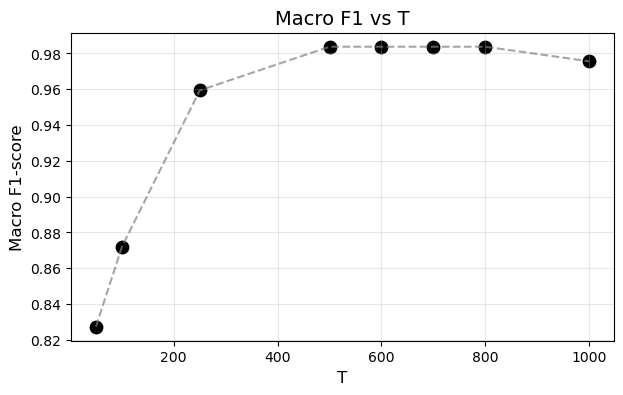

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Prepare dataf1_t600
T_values = np.array([50, 100, 250, 500, 600, 700, 800, 1000])
f1_scores = np.array([f1_t50, f1_t100, f1_t250, f1_t500, f1_t600, f1_t700, f1_t800, f1_t1000])

# Plot dot plot
plt.figure(figsize=(7, 4))
plt.scatter(T_values, f1_scores, s=80, color='black', marker='o')  # dots
plt.plot(T_values, f1_scores, linestyle='--', color='gray', alpha=0.7)  # optional connecting line

# Formatting
plt.xlabel("T", fontsize=12)
plt.ylabel("Macro F1-score", fontsize=12)
plt.title("Macro F1 vs T", fontsize=14)
plt.grid(alpha=0.3)
plt.savefig("timestep_f1.png", dpi=300)
plt.savefig("timestep_f1.svg")
plt.show()